In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import lib
import common

In [18]:
import tensorflow as tf

class SmoothPiecewiseConstantDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, transition_steps, name=None):
        super(SmoothPiecewiseConstantDecay, self).__init__()
        self.boundaries = boundaries
        self.values = values
        self.transition_steps = transition_steps
        self.name = name

    def __call__(self, step):
        # Initialize learning rate to the first value
        lr = tf.constant(self.values[0], dtype=tf.float32)

        # Iterate over the boundaries and values
        for i in range(len(self.boundaries)):
            boundary = tf.constant(self.boundaries[i], dtype=tf.float32)
            target_value = tf.constant(self.values[i + 1], dtype=tf.float32)

            # Apply cosine-based interpolation if within transition steps
            decay_ratio = tf.minimum(
                1.0,
                tf.maximum(0.0, (step - boundary) / self.transition_steps)
            )
            smooth_transition = (
                1 + tf.cos(decay_ratio * tf.constant(3.141592653589793, dtype=tf.float32))
            ) / 2.0

            # Update learning rate to transition between values smoothly
            lr = lr * smooth_transition + target_value * (1 - smooth_transition)

        return lr

    def get_config(self):
        return {
            "boundaries": self.boundaries,
            "values": self.values,
            "transition_steps": self.transition_steps,
            "name": self.name,
        }

# Usage Example
# Define boundaries and values for the smooth transition
boundaries = [1000, 2000, 3000]
values = [0.1, 0.05, 0.1, 0.001]
transition_steps = 500  # Adjust this for smoother (larger) or sharper (smaller) transitions




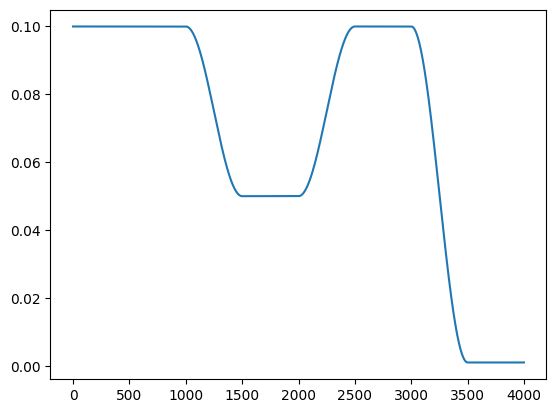

In [19]:
import keras
import matplotlib.pyplot as plt


# lr_schedule = keras.optimizers.schedules.PolynomialDecay(
#     1.0,
#     decay_steps=30,
#     end_learning_rate=0.1,
#     power=2
# )
lr_schedule = SmoothPiecewiseConstantDecay(boundaries, values, transition_steps)
plt.plot([float(lr_schedule(epoch)) for epoch in range(4000)])
plt.show()

In [20]:
def load_exp_interval(x_eval):
    path = "../data/digitized/"

    def load_vals(name: str):
        x, y = (
            pd.read_csv(f"{path}{name}_core2.csv")
            .sort_values("x")
            .reset_index(drop=True)
            .to_numpy()
            .T
        )
        y = np.interp(x_eval, x, y)
        return y / 1000

    y_mean = load_vals("mean")
    y_upper = load_vals("upper_mcmc_PI")
    y_lower = load_vals("lower_mcmc_PI")

    return y_lower, y_mean, y_upper

In [21]:
t_data, y_data = lib.load_exp_data_numpy(name="Core 2")
t_eval = np.linspace(t_data.min(), t_data.max(), 50)

In [22]:
import numpy as np
from scipy.stats import skewnorm
from scipy.optimize import minimize

# Known values
q1 = 0.25
q2 = 0.75
x1 = -1.0
x2 = 2.0
mu = 0.5

# Objective function
def error_function(params):
    xi, omega, alpha = params
    if omega <= 0:
        return np.inf  # Penalize invalid omega values
    theoretical_mu = skewnorm.mean(alpha, loc=xi, scale=omega)
    theoretical_x1 = skewnorm.ppf(q1, alpha, loc=xi, scale=omega)
    theoretical_x2 = skewnorm.ppf(q2, alpha, loc=xi, scale=omega)
    error = (theoretical_x1 - x1)**2 + (theoretical_x2 - x2)**2 + (theoretical_mu - mu)**2
    return error

# Initial guesses (important!)
# initial_guess = [0, 1, 0]
for initial_guess in [0,1,0], [0, 0.1, 0.01]:

    # Optimization
    result = minimize(error_function, initial_guess)
    print(result.fun)

    # Estimated parameters
    xi_est, omega_est, alpha_est = result.x

    print(f"Estimated xi: {xi_est}")
    print(f"Estimated omega: {omega_est}")
    print(f"Estimated alpha: {alpha_est}")
    print()

1.2950745773222905e-09
Estimated xi: 0.3226604413666961
Estimated omega: 2.2309700472024425
Estimated alpha: 0.10014094151550748

2.440612071875719e-10
Estimated xi: 0.36606902284357046
Estimated omega: 2.227936337662158
Estimated alpha: 0.07556386440274887



Quantile q:
x(q)

Equation to solve:

x(q1) = x1
x(q2) = x2

In [23]:
from dataclasses import dataclass


@dataclass
class LikelihoodResult:
    likelihood: np.ndarray
    sigmas: np.ndarray
    mean_gauss: np.ndarray
    bound_gauss_lower: np.ndarray
    bound_gauss_upper: np.ndarray

    def median_likelihood(self):
        return np.median(self.likelihood)

    def mean_likelihood(self, skip: int):
        return np.mean(self.likelihood[skip:])


def compute_loglikelihood_core2_normal(mean, upper, lower, q_upper, q_lower):
    assert q_upper > q_lower
    assert upper > lower

    sigmas = (upper - lower) / (stats.norm.ppf(q_upper) - stats.norm.ppf(q_lower))
    sigmas[sigmas < 1e-14] = 1e-14
    gauss_upper = stats.norm.ppf(q_upper, loc=mean, scale=sigmas)
    gauss_lower = stats.norm.ppf(q_lower, loc=mean, scale=sigmas)

    # interpolation needed because of data_core2_df["c_diss"]
    mean_intp = np.interp(t_data, t_eval, mean)
    sigmas_intp = np.interp(t_data, t_eval, sigmas)
    log_likeli = stats.norm.logpdf(y_data, loc=mean_intp, scale=sigmas_intp)

    return LikelihoodResult(log_likeli, sigmas, mean, gauss_lower, gauss_upper)

TODO: Ich darf nicht das Quantil ausrechnen, indem ich die Punkte zähle. Weil dadurch verbessere ich die Likelihood artifiziell. Siehe dieses Beispiel.

I want to try out a theory I have using numpy. Let's say I have a set of points and an interval and want to compute the likelihood that this data was generated by a gaussian random variable using a set of parameters. One time the mean is computed by the mean of the data and the sigma is computed by assuming that the interval is the 5% and 95% percentile of a gaussian. The second time, the mean is again computed by the mean of the data, but the percentiles are computed by counting the number of points outside of the interval. My theory is that the second approach will always result in a higher likelihood.

Write code for this and visualize everthing along the line using matplotlib.

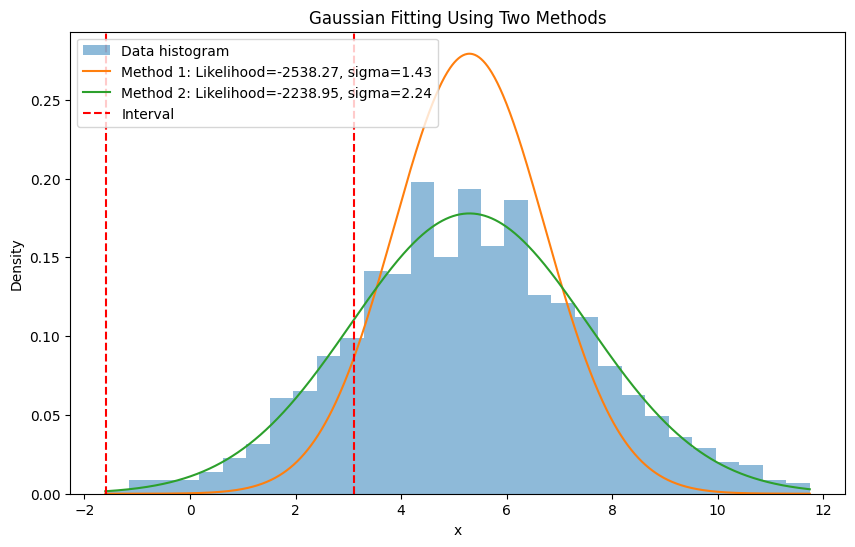

(1.4285714285714286,
 2.2426077675698664,
 -2538.270044246772,
 -2238.9465170166422)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate random data from a normal distribution
np.random.seed(0)
data = np.random.normal(loc=5.4, scale=2.3, size=1000)

# Define the interval
interval = (-1.6, 3.1)

# Compute the mean and standard deviation using both methods
mean_data = np.mean(data)

# Method 1: Interval for sigma estimation
# The 5th and 95th percentiles of a standard normal distribution are -1.645 and 1.645, respectively
sigma1 = (interval[1] - interval[0]) / (2 * 1.645)

# Method 2: Counting points outside of interval
# n_outside = np.sum((data < interval[0]) | (data > interval[1]))
# p_outside = n_outside / len(data)  # Proportion of points outside the interval
p_above = np.count_nonzero(data > interval[1]) / len(data)
p_below = np.count_nonzero(data < interval[0]) / len(data)

# Proportion outside the interval for a normal distribution is 2*(1-CDF(interval))
# p_gaussian_outside = 2 * (1 - norm.cdf(1, loc=0, scale=1))  # for standard normal
# sigma2 = (interval[1] - interval[0]) / (2 * norm.ppf(1 - p_gaussian_outside / 2))
sigma2 = (interval[1] - interval[0]) / (norm.ppf(1 - p_above) - norm.ppf(p_below))

# Likelihood calculation
def gaussian_likelihood(data, mean, sigma):
    return norm.logpdf(data, loc=mean, scale=sigma).sum()

likelihood1 = gaussian_likelihood(data, mean_data, sigma1)
likelihood2 = gaussian_likelihood(data, mean_data, sigma2)

# Visualization
x = np.linspace(min(data), max(data), 1000)
pdf1 = norm.pdf(x, mean_data, sigma1)
pdf2 = norm.pdf(x, mean_data, sigma2)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label="Data histogram")
plt.plot(x, pdf1, label=f"Method 1: Likelihood={likelihood1:.2f}, sigma={sigma1:.2f}")
plt.plot(x, pdf2, label=f"Method 2: Likelihood={likelihood2:.2f}, sigma={sigma2:.2f}")
plt.axvline(interval[0], color='r', linestyle='--', label='Interval')
plt.axvline(interval[1], color='r', linestyle='--')

plt.title("Gaussian Fitting Using Two Methods")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

(sigma1, sigma2, likelihood1, likelihood2)


Method 1: mu=0.10, sigma=0.61, likelihood=-1.5737e+00
Method 2: mu=0.10, sigma=0.97, likelihood=-1.3417e+00
Method 2 is better


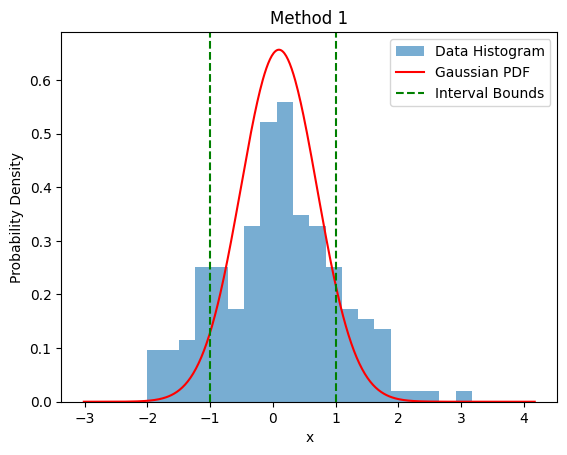

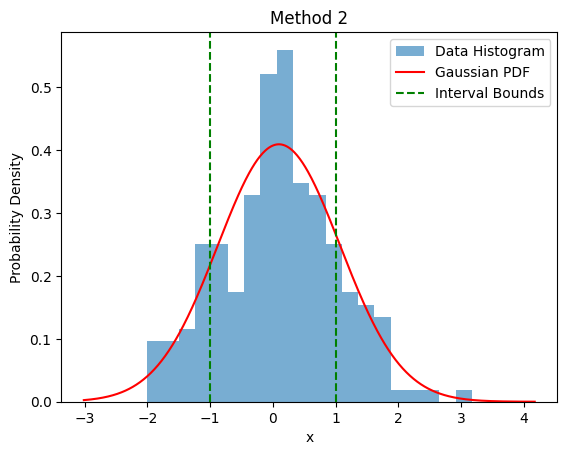

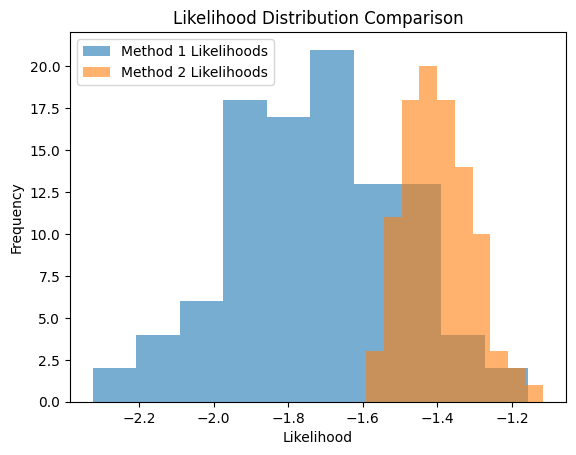

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def gaussian_log_likelihood(data, mu, sigma):
    """Computes the log-likelihood of the data given a Gaussian distribution."""
    return norm.logpdf(data, loc=mu, scale=sigma).mean()


def visualize(data, mu, sigma, interval, title):
    """Visualizes the data, Gaussian distribution, and interval."""
    x = np.linspace(min(data) - 1, max(data) + 1, 500)
    y = norm.pdf(x, loc=mu, scale=sigma)
    plt.hist(data, bins=20, density=True, alpha=0.6, label="Data Histogram")
    plt.plot(x, y, "r-", label="Gaussian PDF")
    plt.axvline(interval[0], color="g", linestyle="--", label="Interval Bounds")
    plt.axvline(interval[1], color="g", linestyle="--")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.show()


def method1(data, interval):
    """Computes mean and sigma assuming interval is 5%-95% percentile."""
    mu = np.mean(data)
    sigma = (interval[1] - interval[0]) / (norm.ppf(0.95) - norm.ppf(0.05))
    return mu, sigma


def method2(data, interval):
    """Computes mean and sigma based on the number of points outside the interval."""
    mu = np.mean(data)
    outside_count = np.sum((data < interval[0]) | (data > interval[1]))
    outside_proportion = outside_count / len(data)
    # Find the z-score corresponding to the outside proportion (two-tailed)
    # z = norm.ppf(1 - outside_proportion / 2)
    # sigma = (interval[1] - mu) / z  # Using upper bound for sigma calculation
    sigma = (interval[1] - interval[0]) / (
        norm.ppf(1 - outside_proportion / 2) - norm.ppf(outside_proportion / 2)
    )
    return mu, sigma


# Example usage
# np.random.seed(42)  # for reproducibility
data = np.random.normal(0, 1, 200)  # Example data:  true mu=0, sigma=1
interval = (-1, 1)  # Example interval

# Method 1
mu1, sigma1 = method1(data, interval)
likelihood1 = gaussian_log_likelihood(data, mu1, sigma1)

# Method 2
mu2, sigma2 = method2(data, interval)
likelihood2 = gaussian_log_likelihood(data, mu2, sigma2)

print(f"Method 1: mu={mu1:.2f}, sigma={sigma1:.2f}, likelihood={likelihood1:.4e}")
print(f"Method 2: mu={mu2:.2f}, sigma={sigma2:.2f}, likelihood={likelihood2:.4e}")

if likelihood1 > likelihood2:
    print("Method 1 is better")
else:
    print("Method 2 is better")

visualize(data, mu1, sigma1, interval, "Method 1")
visualize(data, mu2, sigma2, interval, "Method 2")


# Test the theory over multiple datasets
n_tests = 100
likelihood1_list = []
likelihood2_list = []
for _ in range(n_tests):
    data = np.random.normal(0, 1, 50)
    mu1, sigma1 = method1(data, interval)
    mu2, sigma2 = method2(data, interval)
    likelihood1_list.append(gaussian_log_likelihood(data, mu1, sigma1))
    likelihood2_list.append(gaussian_log_likelihood(data, mu2, sigma2))

plt.hist(likelihood1_list, alpha=0.6, label="Method 1 Likelihoods")
plt.hist(likelihood2_list, alpha=0.6, label="Method 2 Likelihoods")
plt.legend()
plt.xlabel("Likelihood")
plt.ylabel("Frequency")
plt.title("Likelihood Distribution Comparison")
plt.show()

---------

In [26]:
y_lower, y_mean, y_upper = load_exp_interval(t_eval)

skip = 9

is_in_interval = common.is_between_curves(
    t_eval[skip:],
    y_lower[skip:],
    y_upper[skip:],
    np.array([t_data[skip:], y_data[skip:]]).T,
)

computed_quantile = np.count_nonzero(is_in_interval) / len(is_in_interval)

print(f"{computed_quantile*100:.1f}% are in the interval\n")
for q in [0.9, computed_quantile]:
    print(f"Quantile: {q}")
    print(
        f"Likelihood: {compute_loglikelihood_core2_normal(y_mean, y_upper, y_lower, quantile=q).median_likelihood():.2e}"
    )
    print(
        f"Likelihood: {compute_loglikelihood_core2_normal(y_mean, y_upper, y_lower, quantile=q).mean_likelihood(skip=skip):.2e}"
    )
    print()

plt.scatter(
    t_data[skip:], y_data[skip:], c=np.where(is_in_interval, "b", "r"), alpha=0.2
)
plt.plot(t_eval, y_mean, "k-", zorder=-30, alpha=0.7, lw=1)
plt.fill_between(t_eval, y_lower, y_upper, alpha=0.3)
plt.show()

78.3% are in the interval

Quantile: 0.9


TypeError: compute_loglikelihood_core2_normal() got an unexpected keyword argument 'quantile'

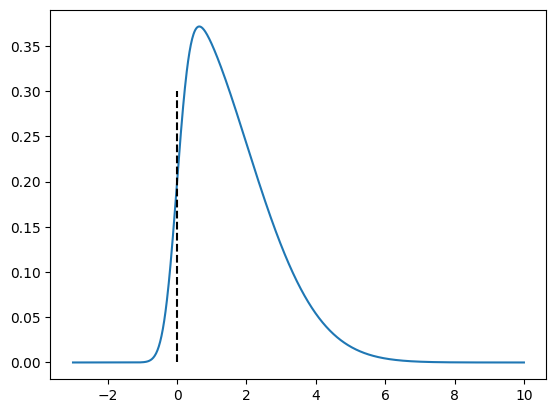

In [30]:
x = np.linspace(-3, 10, 1000)
dist = stats.skewnorm(a=6.4, loc=0, scale=2)
y = dist.pdf(x)

plt.plot(x, y)
plt.vlines(0, 0, 0.3, color="k", linestyle="--")
plt.show()

x% interval means (according to PI3NN):
- x% of data are inside the interval
- x/2% are above median and x/2% are below

In [ ]:
def fit_skew(mean, upper_quantile, lower_quantile, quantile):
    from scipy import optimize

    def loss(a, loc, scale):
        dist = stats.skewnorm(a=a, loc=loc, scale=scale)
        pred_mean = dist.mean()
        pred_upper_quantile, pred_lower_quantile = dist.ppf(
            [upper_quantile, lower_quantile]
        )

In [31]:
mask = x < 3.2897072539029457
np.trapz(y[mask], x[mask])

0.8995419078035993

In [32]:
dist.ppf(0.9)

3.2897072539029457

[2.15035386 2.216579   1.08284497]
True
3.2022124147012246e-11
Mean: 2.999995624478398 (vs. actual: 3)
Area: 0.9000067006760111 (vs. actual: 0.9)


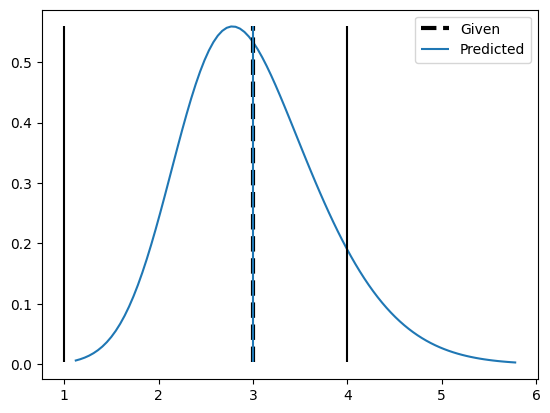

In [47]:
from scipy import optimize

# check if there are multiple solutions that have the given mean and give a x% interval that has the given bounds.
mean = 3
ub = 4
lb = 1

predictive_quality = 0.9


def loss(params):
    a, loc, scale = params
    dist = stats.skewnorm(a=a, loc=loc, scale=scale)
    pred_mean = dist.mean()
    area = dist.cdf(ub) - dist.cdf(lb)
    return (np.square(area - predictive_quality) + np.square(pred_mean - mean)) / 2


def check_correctness(dist):
    print(f"Mean: {dist.mean()} (vs. actual: {mean})")
    print(f"Area: {dist.cdf(ub) - dist.cdf(lb)} (vs. actual: {predictive_quality})")


result = optimize.minimize(loss, x0=[1, 0, 1])
print(result.x)
print(result.success)
print(result.fun)
a, loc, scale = result.x

dist = stats.skewnorm(a=a, loc=loc, scale=scale)
check_correctness(dist)

x = np.linspace(*dist.ppf([0.001, 0.999]), 100)
y = dist.pdf(x)
pred_mean = dist.mean()
# pred_ub

plt.plot(x, y)
plt.vlines(mean, y.min(), y.max(), color="black", linestyles="--", label="Given", lw=3)
plt.vlines([lb, ub], y.min(), y.max(), color="black", linestyles="-")
plt.vlines(pred_mean, y.min(), y.max(), color="C0", label="Predicted")
plt.legend()
plt.show()

[1.36723001 2.36110851 0.99204741]
True
7.095261930743381e-12
Mean: 2.9999965189817956 (vs. actual: 3)
Area: 0.8999985601958042 (vs. actual: 0.9)


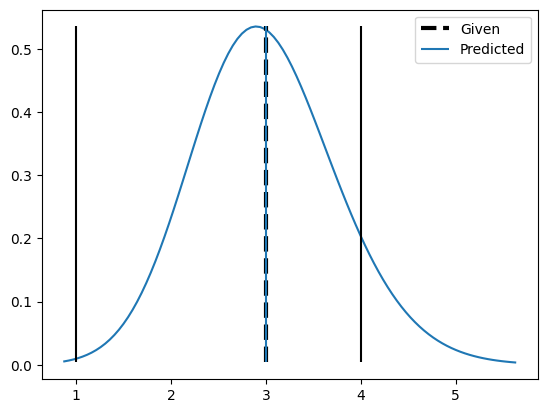

In [49]:
result = optimize.minimize(loss, x0=[0, 0, 1])
print(result.x)
print(result.success)
print(result.fun)
a, loc, scale = result.x

dist = stats.skewnorm(a=a, loc=loc, scale=scale)
check_correctness(dist)

x = np.linspace(*dist.ppf([0.001, 0.999]), 100)
y = dist.pdf(x)
pred_mean = dist.mean()
# pred_ub

plt.plot(x, y)
plt.vlines(mean, y.min(), y.max(), color="black", linestyles="--", label="Given", lw=3)
plt.vlines([lb, ub], y.min(), y.max(), color="black", linestyles="-")
plt.vlines(pred_mean, y.min(), y.max(), color="C0", label="Predicted")
plt.legend()
plt.show()

Wie man sieht, sind das zwei ziemlich unterschiedliche Ergebnisse.

[2.99999661 0.76480626]
True
2.454084235702859e-10
Mean: 2.999996605681189 (vs. actual: 3)
Area: 0.9000218928172457 (vs. actual: 0.9)


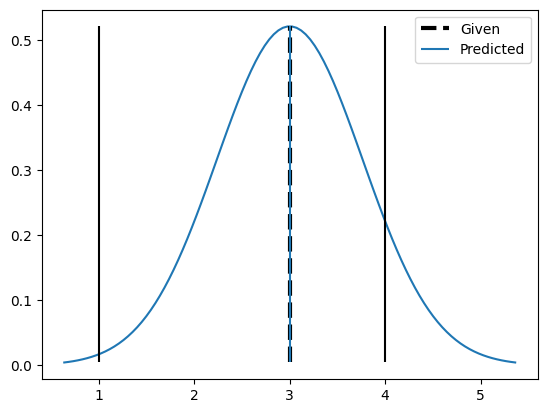

In [51]:
def loss(params):
    loc, scale = params
    dist = stats.norm(loc=loc, scale=scale)
    pred_mean = dist.mean()
    area = dist.cdf(ub) - dist.cdf(lb)
    return (np.square(area - predictive_quality) + np.square(pred_mean - mean)) / 2


result = optimize.minimize(loss, x0=[0, 1])
print(result.x)
print(result.success)
print(result.fun)
loc, scale = result.x

dist = stats.norm(loc=loc, scale=scale)
check_correctness(dist)

x = np.linspace(*dist.ppf([0.001, 0.999]), 100)
y = dist.pdf(x)
pred_mean = dist.mean()
# pred_ub

plt.plot(x, y)
plt.vlines(mean, y.min(), y.max(), color="black", linestyles="--", label="Given", lw=3)
plt.vlines([lb, ub], y.min(), y.max(), color="black", linestyles="-")
plt.vlines(pred_mean, y.min(), y.max(), color="C0", label="Predicted")
plt.legend()
plt.show()

[0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5]


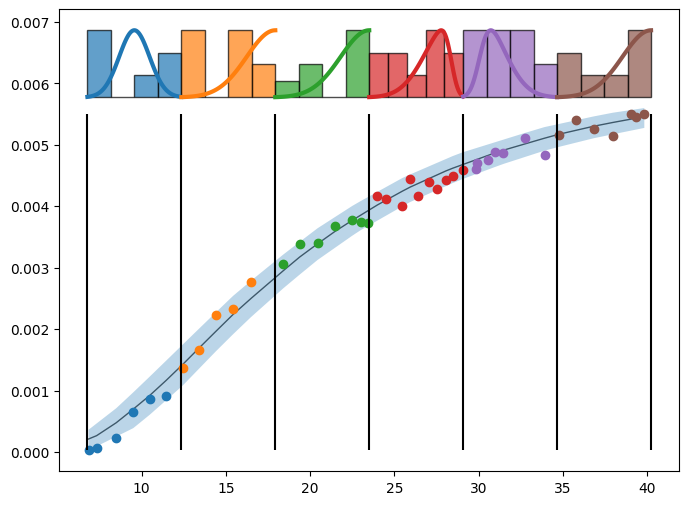

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have loaded data using lib
x, y = lib.load_exp_data_numpy("Core 2")
x = x[13:]
y = y[13:]
y_lower, y_mean, y_upper = load_exp_interval(x)

# Define bins and compute bin indices
bins = np.linspace(x.min() * 0.99, x.max() * 1.01, 7)
bin_width = bins[1] - bins[0]
bin_indices = np.digitize(x, bins) - 1  # Subtract 1 to align indices with bins

# Subset indices for each bin
subset_indices = [np.where(bin_indices == i)[0] for i in range(len(bins) - 1)]

# Create extra space on top for histograms
y_max = y.max()
plt.figure(figsize=(8, 6))

plt.plot(x, y_mean, "k-", zorder=-30, alpha=0.7, lw=1)
plt.fill_between(x, y_lower, y_upper, alpha=0.3)

# Plot the scatter data
plt.vlines(bins, y.min(), y_max, color="black")
for i in range(len(x)):
    plt.scatter(x[i], y[i], color=f"C{bin_indices[i]}")


dists = []

for i, indices in enumerate(subset_indices):
    if len(indices) > 0:
        subset_y = y[indices]

        # Compute histogram for the y values in this subset
        hist, bin_edges = np.histogram(subset_y, bins="auto", density=True)
        hist *= (y_max - y.min()) / hist.max() * 0.2
        bin_edges -= bin_edges.min()
        bin_edges /= bin_edges.max()
        bin_edges *= bin_width
        bin_edges += bins[i]

        # fit a skewnorm
        params = stats.skewnorm.fit(subset_y)
        dist = stats.skewnorm(*params)
        dists.append(dist)
        x_pdf = np.linspace(*dist.ppf([0.001, 0.999]), 100)
        x_plot = x_pdf - x_pdf.min()
        x_plot /= x_plot.max()
        x_plot *= bin_width
        x_plot += bins[i]
        y_pdf = dist.pdf(x_pdf)
        y_plot = 1.05 * y_max + y_pdf * (y_max - y.min()) / y_pdf.max() * 0.2
        plt.plot(x_plot, y_plot, "-", color=f"C{i}", lw=3)

        # Plot the histogram just above the data
        for j in range(len(hist)):
            left = bin_edges[j]
            right = bin_edges[j + 1]
            width = right - left

            # Plot each bar of the histogram horizontally (above the scatter)
            plt.bar(
                x=(left + right) / 2,
                height=hist[j],
                width=width,
                bottom=1.05 * y_max,
                color=f"C{i}",
                alpha=0.7,
                edgecolor="black",
            )

plt.show()

In [145]:
1 - predictive_quality - eps

0.09999999899999998

In [149]:
print(target)
print(dist.ppf(1e-9))
print(dist.ppf(1e-4))
print(dist.ppf(1e-2))
print(dist.ppf(0.05))
print(dist.ppf(1 - predictive_quality - eps))
print(dist.ppf(0.09999999899999998))

0.00040378239282658326
-0.0017193299196096431
-0.0008924044237764698
-0.0003868757360290778
-0.0001394501367173545
-7.534876758601714e-06
-7.534876758601714e-06


True
Final value: 0.0499
1.1e-16
True
Final value: 0.1000
0.0e+00
True
Final value: 0.0814
-3.3e-16
True
Final value: 0.0783
3.3e-16
True
Final value: 0.0625
4.4e-16
True
Final value: 0.0890
0.0e+00


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9207: RuntimeWarning: overflow encountered in _skewnorm_ppf
  return _boost._skewnorm_ppf(x, 0, 1, a)


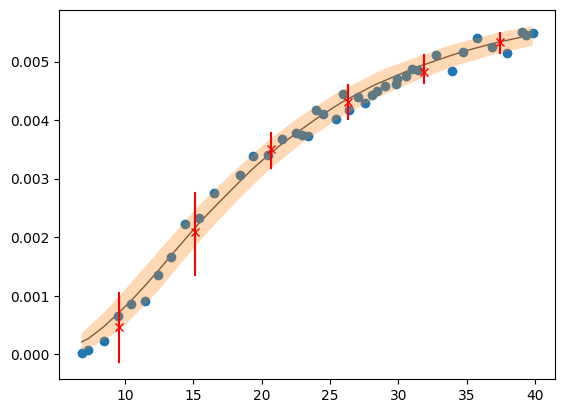

In [155]:
plt.scatter(x, y)

bin_centers = (bins[:-1] + bins[1:]) / 2

for i, dist in enumerate(dists):
    target_lower = np.interp(bin_centers[i], x, y_lower)
    target_upper = np.interp(bin_centers[i], x, y_upper)

    def f(q_low):
        lb, ub = dist.ppf([q_low, q_low + predictive_quality])
        return (abs(lb - target_lower) + abs(ub - target_upper)) / 2

    eps = 1e-9
    result = optimize.minimize(f, eps * 2, bounds=[(eps, 1 - predictive_quality - eps)])
    print(result.success)
    start = result.x[0]
    assert start + predictive_quality < 1.0
    lb, ub = dist.ppf([start, start + predictive_quality])

    print(f"Final value: {start:.4f}")
    print(f"{dist.cdf(ub) - dist.cdf(lb) - predictive_quality:.1e}")
    plt.plot(bin_centers[i], dist.mean(), "rx")
    plt.plot([bin_centers[i], bin_centers[i]], [lb, ub], "r-")


plt.plot(x, y_mean, "k-", zorder=-30, alpha=0.7, lw=1)
plt.fill_between(x, y_lower, y_upper, alpha=0.3)
plt.show()